In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/augmented-eyes-4/dataframe_bueno.pkl
/kaggle/input/augmented-eyes-4/y_train.npy
/kaggle/input/augmented-eyes-4/X2_train.npy
/kaggle/input/augmented-eyes-4/name_file_test.npy
/kaggle/input/augmented-eyes-4/y_test.npy
/kaggle/input/augmented-eyes-4/__results__.html
/kaggle/input/augmented-eyes-4/name_file_train.npy
/kaggle/input/augmented-eyes-4/dataframe.pkl
/kaggle/input/augmented-eyes-4/X2_test.npy
/kaggle/input/augmented-eyes-4/X1_train.npy
/kaggle/input/augmented-eyes-4/__notebook__.ipynb
/kaggle/input/augmented-eyes-4/X1_test.npy
/kaggle/input/augmented-eyes-4/__output__.json
/kaggle/input/augmented-eyes-4/X0_test.npy
/kaggle/input/augmented-eyes-4/X0_train.npy
/kaggle/input/augmented-eyes-4/custom.css
/kaggle/input/augmented-eyes-4/__results___files/__results___13_0.png


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
from keras.layers import BatchNormalization, concatenate
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

2024-02-26 04:12:54.562763: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 04:12:54.562822: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 04:12:54.564286: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
width = 224
height = 224
batch_size = 32

In [4]:
def load_data(file_x0,file_x1,file_x2, file_y):
    """
        Reading numpy data files
    """

    X0 = np.load('/kaggle/input/augmented-eyes-4/'+file_x0)
    X1 = np.load('/kaggle/input/augmented-eyes-4/'+file_x1)
    X2 = np.load('/kaggle/input/augmented-eyes-4/'+file_x2)
    y = np.load('/kaggle/input/augmented-eyes-4/'+file_y)
    
    ohe = OneHotEncoder()
    X2 = ohe.fit_transform(X2.reshape(-1,1)).toarray()
    y = ohe.fit_transform(y.reshape(-1,1)).toarray()
     
    return (X0 , X1, X2, y)

In [5]:
#  Load data, and change type for speed
(X0_train, X1_train, X2_train, y_train)= load_data('X0_train.npy', 'X1_train.npy',
                                                   'X2_train.npy', 'y_train.npy')
(X0_test, X1_test, X2_test, y_test)= load_data('X0_test.npy', 'X1_test.npy',
                                                   'X2_test.npy', 'y_test.npy')

X0_train = X0_train.astype('uint8')
X0_test = X0_test.astype('uint8')

X1_train = X1_train.astype('uint8')
X1_test = X1_test.astype('uint8')

X2_train = X2_train.astype('uint8')
X2_test = X2_test.astype('uint8')

y_test = y_test.astype('uint8')
y_train = y_train.astype('uint8')

In [6]:
# Reshape ages to be a 2D array
X1_train = X1_train.reshape(-1, 1)
X1_test = X1_test.reshape(-1, 1)

# Combine the arrays
combined_train = np.hstack((X1_train, X2_train))
combined_test = np.hstack((X1_test, X2_test))

In [7]:
#Class that create the model with some evaluations

class CompleteModel:
    """
    Transfer Learning Convolutional Neural Network initialized with pretrained weights.
   
    """

    def __init__(self, model_type, dropout_rate_1, dropout_rate_2):
        self.training_history = None
        self.model_type = model_type
        self.y_pred = None
        
        self.X0_test = None
        self.combined_test = None
        self.y_test = None
        self.validation_data = None
        self.defined_metrics = [tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
                   tf.keras.metrics.Precision(name='precision'),
                   tf.keras.metrics.Recall(name='recall')]
        self._init_model(dropout_rate_1=dropout_rate_1, dropout_rate_2=dropout_rate_2)
    
    def _init_model(self, dropout_rate_1=0.46634, dropout_rate_2=0.3767, activation='relu'):
        """
        Initializing the base model and adding the attention model
        """
        
        # MLP Model
        mlp_input = Input(shape=(3,))
        mlp = Dense(units=4, activation='relu')(mlp_input)
        mlp = Dense(units=1, activation='relu')(mlp)
        
        # CNN Model
        input_l = Input((224, 224, 3)) #Change the value respecting your dataset
        base_model = InceptionV3(input_shape =  (224, 224, 3), include_top = False, weights = 'imagenet')
        base_model.trainable = True
        pt_features = base_model(input_l)
        bn_features = BatchNormalization()(pt_features)
        pt_depth = base_model.get_output_shape_at(0)[-1]

        attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', 
                            activation = 'relu')(Dropout(0.46634)(bn_features))
        attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', 
                            activation = 'relu')(attn_layer)
        attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', 
                            activation = 'relu')(attn_layer)
        attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', 
                            activation = 'sigmoid')(attn_layer)

        up_c2_w = np.ones((1, 1, 1, pt_depth))
        up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
                       activation = 'linear', use_bias = False, weights = [up_c2_w])
        up_c2.trainable = False
        attn_layer = up_c2(attn_layer)
        
        mask_features = multiply([attn_layer, bn_features])
        gap_features = GlobalAveragePooling2D()(mask_features)
        gap_mask = GlobalAveragePooling2D()(attn_layer)

        # to account for missing values from the attention model
        gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
        gap_dr = Dropout(0.3767)(gap)
        dr_steps = Dropout(0.3767)(Dense(128, activation = 'relu')(gap_dr))
        
        combined_layer = concatenate([mlp, dr_steps])
        dense = combined_layer
        for _ in range(0):
            dense = Dense(units=57, activation='relu')(dense)
        out_layer = Dense(y_train.shape[-1], activation='softmax')(dense)

        self.model = Model(inputs=[mlp_input, input_l], outputs=out_layer)
        
    def _get_base_model(self):
        """
        Initialize the base model
        """
        if self.model_type == 'inception_v3':
            return InceptionV3(weights='imagenet', include_top=False,input_shape=(height, width, 3))
        elif self.model_type == 'xception':
            return Xception(weights='imagenet', include_top=False,input_shape=(height, width, 3))
        elif self.model_type == 'vgg16':
            return VGG16(weights='imagenet', include_top=False,input_shape=(height, width, 3))
        elif self.model_type == 'vgg19':
            return VGG19(weights='imagenet', include_top=False,input_shape=(height, width, 3))
        elif self.model_type == 'resnet':
            return ResNet50(weights='imagenet', include_top=False,input_shape=(height, width, 3))
        else:
            raise ValueError('Cannot find base model %s' % self.model_type)
            
    def fit(self, X0_train, X0_test, combined_train, combined_test, y_train, y_test, epochs=50):
        """
        Network training
        """
        self.combined_test = combined_test
        self.X0_test = X0_test
        self.y_test = y_test

        # optimizer
        optimize_adam = tf.keras.optimizers.Adam(learning_rate=0.00019559, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

        optimize_sgd = tf.keras.optimizers.SGD(learning_rate=0.00042746, momentum=0.9, nesterov=True)
        
        # callbacks
        weight_path="{}_weights.best.hdf5".format('retina')

        checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min', save_weights_only = True)

        reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                           patience=3, verbose=1, mode='auto', 
                                           epsilon=0.0001, cooldown=5, min_lr=0.0001)
        early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
        callbacks_list = [checkpoint, early, reduceLROnPlat]
        
        # compile
        self.model.compile(optimizer=optimize_sgd, loss='categorical_crossentropy', metrics=self.defined_metrics)
        
        # fit
        self.training_history = self.model.fit(x=[combined_train, X0_train], y=y_train, epochs=40,
                                                    callbacks=callbacks_list,
                                                    shuffle=True,
                                                    validation_data=([combined_test, X0_test], y_test)) 
        # predict
        self.y_pred = self.model.predict(x=[combined_test, X0_test])
        
    def plot_metrics(self):
        """
        Plots the accuracy and loss curves using matplotlib.
        """
        acc = self.training_history.history['accuracy']
        val_acc = self.training_history.history['val_accuracy']
        loss = self.training_history.history['loss']
        val_loss = self.training_history.history['val_loss']

        epochs = range(len(acc))

        plt.figure(figsize=(10, 6))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')

        plt.show()
        
    def get_training(self):
        """
        Return training history
        """
        return self.training_history

    def print_evaluation(self):
        """
        Print evaluation metrics for the model on the test dataset.
        """
        results = self.model.evaluate([self.combined_test, self.X0_test], self.y_test, verbose=2)
        print("Test Loss:", results[0])
        
        for i, metric_name in enumerate(self.model.metrics_names[1:]):  # Exclude the first element (loss)
            print(f"Test {metric_name}: {results[i + 1]:.4f}")

        # Flatten the true and predicted labels for further analysis
        y_test_flat = np.argmax(self.y_test, axis=1)
        y_pred_flat = np.argmax(self.y_pred, axis=1)

        kappa = metrics.cohen_kappa_score(y_test_flat, y_pred_flat)
        f1 = metrics.f1_score(y_test_flat, y_pred_flat, average='micro')

        print('\nAdditional Metrics:')
        print('Cohen Kappa Score:', kappa)
        print('F1 Score:', f1)

        
    def plot_accuracy(self):
        """
        Plots the accuracy curve using matplotlib.
        """
        acc = self.training_history.history['accuracy']
        val_acc = self.training_history.history['val_accuracy']
        epochs = range(len(acc))

        plt.figure(figsize=(8, 6))
        plt.plot(epochs, acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Accuracy')
        plt.show()
        
    def plot_confusion_matrix(self, y_true, y_pred):
        """
        Plots the confusion matrix using matplotlib.
        """
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import ConfusionMatrixDisplay

        # Convert probabilities to class labels
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Ensure y_true is 1D
        y_true = np.argmax(y_true, axis=1)

        cm = confusion_matrix(y_true, y_pred_classes)

        # Use ConfusionMatrixDisplay for better visualization
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                      display_labels=['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Others'])
        disp.plot(cmap='Blues', values_format='d')

        # Display the actual numbers representing wrong predictions on the plot
        for i in range(len(disp.display_labels)):
            for j in range(len(disp.display_labels)):
                if i != j:
                    plt.text(j, i, format(cm[i, j], 'd'),
                             ha='center', va='center', color='red', fontsize=8)

        plt.title('Confusion Matrix with Wrong Predictions')
        plt.show()
    
    def saveHist(self, path):
        """
        Saving the learning curve
        """
        pickle.dump(self.training_history, open(path, 'wb'))
    
    def loadHist(self, path):
        self.training_history.history = np.load(path, allow_pickle='TRUE').item()


In [8]:
model = CompleteModel(model_type='vgg16',dropout_rate_1=0.46634, dropout_rate_2=0.3767)

In [9]:
model.fit(X0_train, X0_test, combined_train, combined_test, y_train, y_test, epochs=40)

Epoch 1/40


2024-02-26 04:13:21.575879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708920806.670526     530 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


570/570 [==============================] - ETA: 0s - loss: 1.5818 - accuracy: 0.4140 - precision: 0.7692 - recall: 0.2252
Epoch 1: val_loss improved from inf to 1.19339, saving model to retina_weights.best.hdf5
570/570 [==============================] - 134s 188ms/step - loss: 1.5818 - accuracy: 0.4140 - precision: 0.7692 - recall: 0.2252 - val_loss: 1.1934 - val_accuracy: 0.5535 - val_precision: 0.8260 - val_recall: 0.3643 - lr: 4.2746e-04
Epoch 2/40
570/570 [==============================] - ETA: 0s - loss: 1.0901 - accuracy: 0.5987 - precision: 0.8007 - recall: 0.4353
Epoch 2: val_loss improved from 1.19339 to 0.91231, saving model to retina_weights.best.hdf5
570/570 [==============================] - 98s 172ms/step - loss: 1.0901 - accuracy: 0.5987 - precision: 0.8007 - recall: 0.4353 - val_loss: 0.9123 - val_accuracy: 0.6579 - val_precision: 0.8490 - val_recall: 0.5092 - lr: 4.2746e-04
Epoch 3/40
570/570 [==============================] - ETA: 0s - loss: 0.8237 - accuracy: 0.6968 

In [10]:
model.model.save('/kaggle/working/modelxception.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


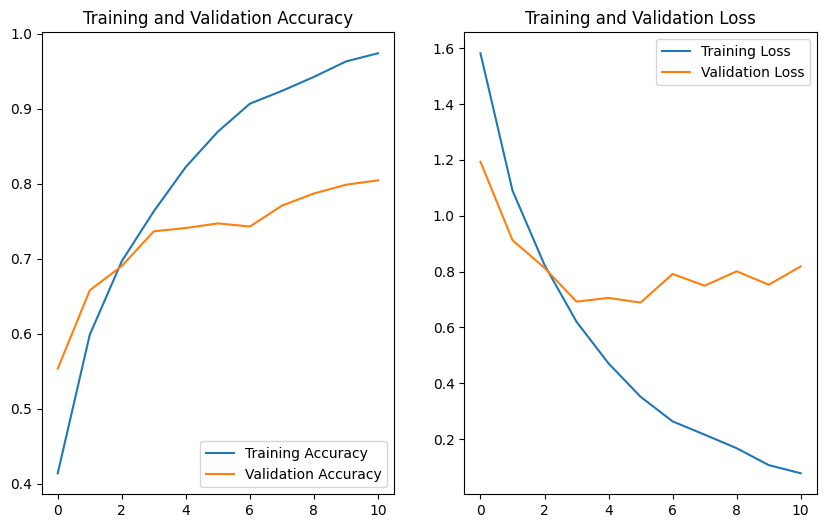

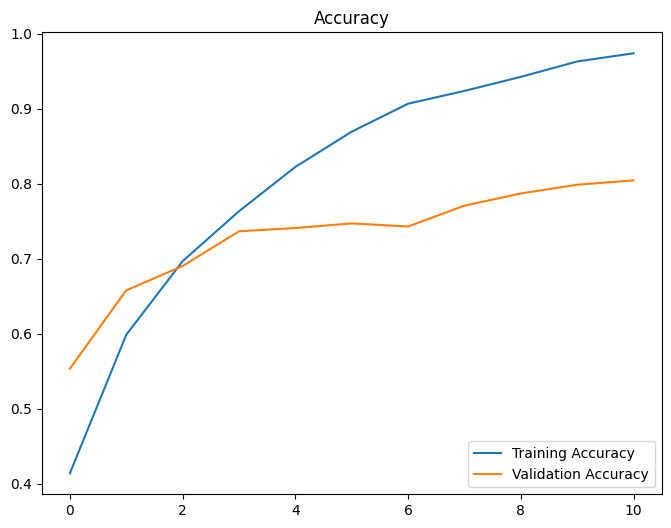

In [11]:
model.plot_metrics()
model.plot_accuracy()

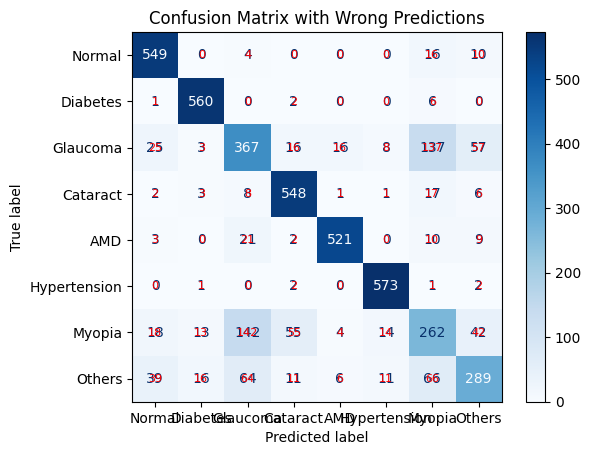

In [12]:
model.plot_confusion_matrix(y_true=y_test, y_pred=model.y_pred)

143/143 - 6s - loss: 0.8182 - accuracy: 0.8046 - precision: 0.8151 - recall: 0.7958 - 6s/epoch - 41ms/step
Test Loss: 0.8182259798049927
Test accuracy: 0.8046
Test precision: 0.8151
Test recall: 0.7958

Additional Metrics:
Cohen Kappa Score: 0.7764974187755679
F1 Score: 0.8046052631578947


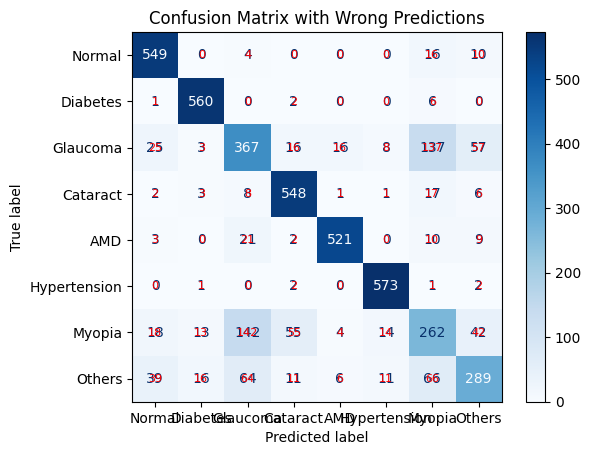

In [13]:
model.print_evaluation()